In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.sparse import vstack, csr_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import PowerTransformer

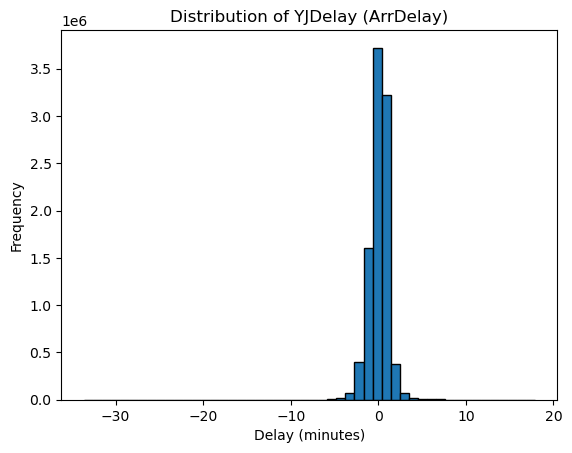

In [6]:
data = pd.read_csv("final_data.csv")
data['Year']=data['Year'].astype('category')
data['Month']=data['Month'].astype('category')
data['DayOfWeek']=data['DayOfWeek'].astype('category')
data['Operating_Airline ']=data['Operating_Airline '].astype('category')
data['Origin']=data['Origin'].astype('category')
data['Dest']=data['Dest'].astype('category')
data['DepTimeBlk'] = data['DepTimeBlk'].astype('category')
data['ArrTimeBlk'] = data['ArrTimeBlk'].astype('category')
data['Origin_HourlyWindDirection'] = data['Origin_HourlyWindDirection'].astype('category')
data['Dest_HourlyWindDirection'] = data['Dest_HourlyWindDirection'].astype('category')
data['Holiday'] = data['Holiday'].astype('category')
data['Cancelled'] = data['Cancelled'].astype('category')
data = data.drop(columns=['ActualElapsedTime'])

continuous_columns = data.select_dtypes(include=['float64', 'int64']).columns

data = data[data['Cancelled'] != 1]
min_arr_delay = data['ArrDelay'].min()
data = data[data['ArrDelay'] != min_arr_delay]  # Remove row with minimum ArrDelay
data = data.dropna(subset=['ArrDelay'])
pt = PowerTransformer(method='yeo-johnson')
data['YJArrDelay'] = pt.fit_transform(data[['ArrDelay']])

plt.hist(data['YJArrDelay'].dropna(), bins=50, edgecolor='black')
plt.title("Distribution of YJDelay (ArrDelay)")
plt.xlabel("Delay (minutes)")
plt.ylabel("Frequency")
plt.show()

### one hot

In [7]:
data = data.sample(frac=0.1, random_state=42)

# Define features and target variable
X = data.drop(columns=['Cancelled', 'DepDelay', 'ArrDelay','YJArrDelay'])
y = data['ArrDelay']

categorical_features = X.select_dtypes(include=['category']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  
)
preprocessor.fit(X) 

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat', OneHotEncoder(handle_unknown='ignore'),
                                 Index(['Year', 'Month', 'DayOfWeek', 'Operating_Airline ', 'Origin', 'Dest',
       'DepTimeBlk', 'ArrTimeBlk', 'Origin_HourlyWindDirection',
       'Dest_HourlyWindDirection', 'Holiday'],
      dtype='object'))])

In [8]:
from scipy.sparse import vstack, csr_matrix

chunk_size = 500000  
X_transformed = csr_matrix((0, len(preprocessor.transform(X.iloc[:1]).toarray()[0])))

for start_row in range(0, len(X), chunk_size):
    end_row = min(start_row + chunk_size, len(X))
    data_chunk = X.iloc[start_row:end_row]  

    X_transformed_chunk = preprocessor.transform(data_chunk)

    print(f"Chunk shape: {X_transformed_chunk.shape}")

    X_transformed = vstack([X_transformed, X_transformed_chunk])

print(f"Transformed data shape: {X_transformed.shape}")

Chunk shape: (500000, 897)
Chunk shape: (450969, 897)
Transformed data shape: (950969, 897)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=123)

categories = preprocessor.transformers_[0][1].categories_

encoded_feature_names = []
for feature, category in zip(categorical_features, categories):
    encoded_feature_names.extend([f"{feature}_{cat}" for cat in category])

numerical_feature_names_org = preprocessor.transformers_[1][2] if len(preprocessor.transformers_) > 1 else []
numerical_feature_names = []

for index in numerical_feature_names_org:
    if isinstance(index, int) and index < len(data.columns):
        numerical_feature_names.append(data.columns[index])
    else:
        numerical_feature_names.append(index)

all_feature_names = encoded_feature_names + numerical_feature_names

### linear regression

In [10]:
# Initialize the linear regression model
model = LinearRegression()

# Train the model on the training set
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model using various metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R² Score:", r2)

Mean Squared Error (MSE): 0.9288143760541698
Root Mean Squared Error (RMSE): 0.9637501626740044
Mean Absolute Error (MAE): 0.7235068950719311
R² Score: 0.07308614765941046


y_train_transformed_pred = model.predict(X_train)
y_test_transformed_pred = model.predict(X_test)

y_train_pred = pt.inverse_transform(y_train_transformed_pred.reshape(-1, 1)).ravel()
y_test_pred = pt.inverse_transform(y_test_transformed_pred.reshape(-1, 1)).ravel()
y_train_true = pt.inverse_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_true = pt.inverse_transform(y_test.values.reshape(-1, 1)).ravel()

train_mse = mean_squared_error(y_train_true, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train_true, y_train_pred)
train_r2 = r2_score(y_train_true, y_train_pred)

test_mse = mean_squared_error(y_test_true, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test_true, y_test_pred)
test_r2 = r2_score(y_test_true, y_test_pred)

print("Training Set Metrics (Original Scale):")
print("Mean Squared Error:", train_mse)
print("Root Mean Squared Error:", train_rmse)
print("Mean Absolute Error:", train_mae)
print("R² Score:", train_r2)

print("\nTesting Set Metrics (Original Scale):")
print("Mean Squared Error:", test_mse)
print("Root Mean Squared Error:", test_rmse)
print("Mean Absolute Error:", test_mae)
print("R² Score:", test_r2)